# Supplementary Exercises

```{warning}
This page contains solutions! We recommend attempting each problem before peeking.
```

## 1. Laplace’s Method for Binomial-Beta
Approximate the posterior by a normal model using Laplace’s method. The likelihood is binomial $X \mid p \sim \text{Bin}(n, p)$ and the prior is $p \sim \text{Be}(\alpha, \beta)$ with parameters:

1. $\alpha = \beta = 1$ (flat prior)

2. $\alpha = \beta = 1/2$ (Jeffreys’ prior)

3. $\alpha = \beta = 2$

How well does Laplace’s method approximate the 95% credible set (CS) for $p$? Compare exact equi-tailed CS’s with the approximations. Use $n = 20$ and $X = 8$.

```{admonition} Solution
:class: tip, dropdown

See [](Unit5-Laplace.ipynb) for the steps for Laplace's method. Most of the code below is from there.

Our model: 

\begin{align*} 
X|p &\sim \text{Bin}(n, p) \\ 
p &\sim \text{Be}(\alpha, \beta)
\end{align*} 

This is conjugate, with an exact posterior of $\text{Be}(\alpha + x, \beta + n - x)$.

The log-posterior (with fixed $n$) and one datapoint: 

\begin{align*} 
\pi(p) & \propto p^x (1-p)^{n-x} p^{\alpha - 1}(1-p)^{\beta - 1}\\
log \pi(p) &\propto \log \left[ p^x (1-p)^{n-x} p^{\alpha - 1}(1-p)^{\beta - 1} \right]\\
&\propto \log \left[ p^{x +\alpha - 1}(1-p)^{n - x + \beta - 1} \right]\\
&\propto (x + \alpha -1)\log(p) + (n - x + \beta - 1)\log(1-p)
\end{align*} 

We could simplify further and find the mode but I'm just going to use code.

1. $\alpha = \beta = 1$

Exact posterior is $\text{Be}(9, 13)$.

2. $\alpha = \beta = \frac{1}{2}$

Exact posterior is $\text{Be}(8.5, 12.5)$.

3. $\alpha = \beta = 2$.

Exact posterior is $\text{Be}(10, 14)$​.

The code in the hidden cell below solves all three problems.
```

Exact 95% credible interval: (0.22, 0.62)
Laplace approximation 95% credible interval: (0.19, 0.61)


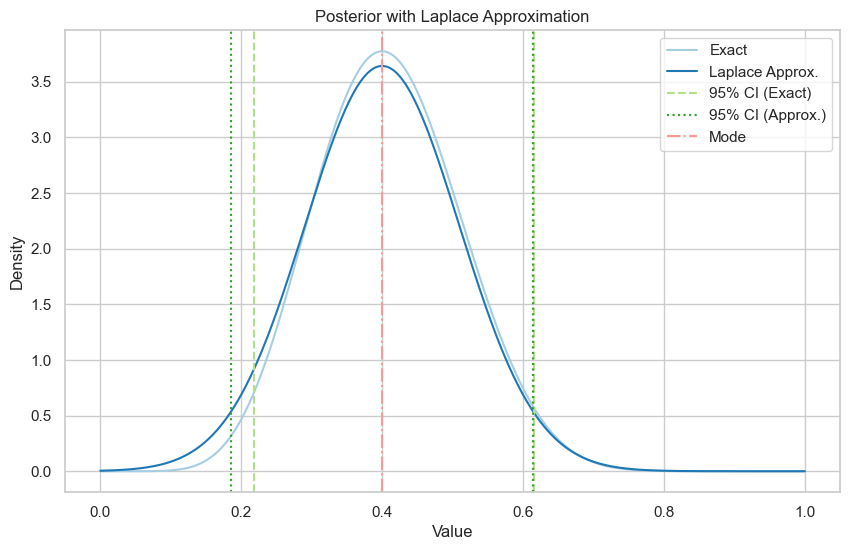

Exact 95% credible interval: (0.21, 0.62)
Laplace approximation 95% credible interval: (0.17, 0.61)


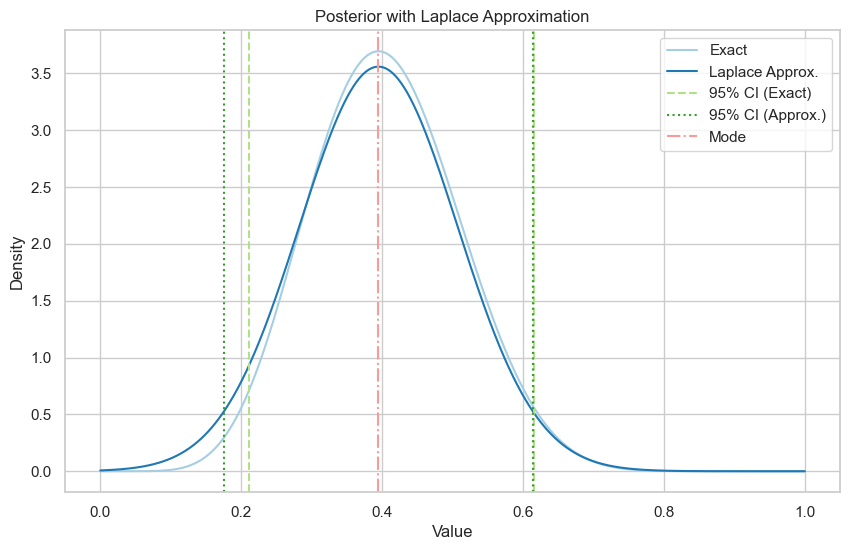

Exact 95% credible interval: (0.23, 0.61)
Laplace approximation 95% credible interval: (0.20, 0.61)


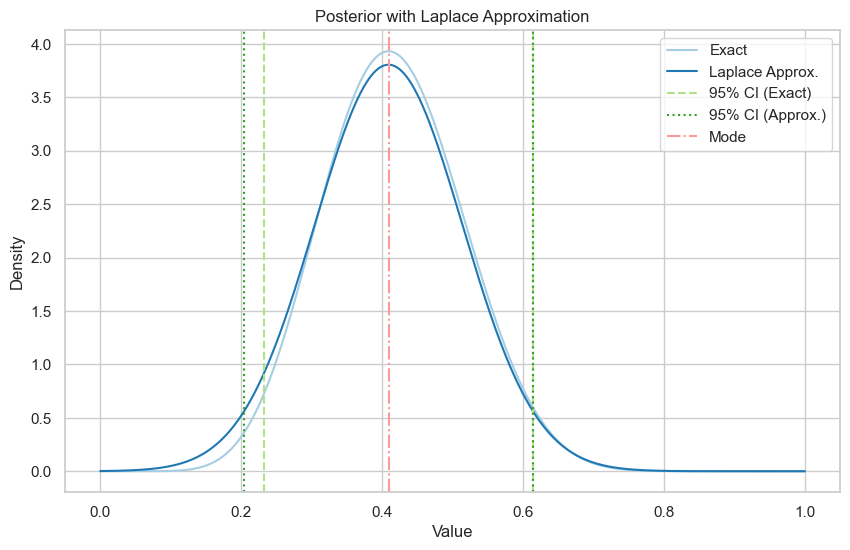

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, norm
from scipy.optimize import minimize_scalar
from sympy import symbols, log, diff, lambdify

sns.set(style="whitegrid")
colors = sns.color_palette("Paired")

# get Q (variance approximation) using Sympy
p, α, β, n, x = symbols("p α β n x")
Q_eq = -((x + α - 1) * log(p) + (n - x + β - 1) * log(1 - p))
Q_inv = diff(Q_eq, p, 2)
Q_func = lambdify((p, α, β, n, x), 1 / Q_inv.simplify())

# constant values
n, x = 20, 8
alphabeta_list = [(1, 1), (0.5, 0.5), (2, 2)]  # a, b, c


# negative log posterior function for optimization
def neg_log_post(p, α, β, n, x):
    return -((x + α - 1) * np.log(p) + (n - x + β - 1) * np.log(1 - p))


# find mode
def get_mode(α, β, n, x):
    result = minimize_scalar(
        neg_log_post, bounds=(0, 1), args=(α, β, n, x), method="bounded"
    )
    return result.x


p_modes = [get_mode(α, β, n, x) for α, β in alphabeta_list]


def print_comparisons_and_plot(mode, alphabeta, n, x):
    α, β = alphabeta
    xx = np.linspace(0, 1, 1000)
    mu = mode
    sigma = np.sqrt(Q_func(mode, α, β, n, x))

    exact_post = beta(a=α + x, b=β + n - x)
    approx_post = norm(mu, sigma)

    # credible intervals
    exact_ci = exact_post.ppf(0.025), exact_post.ppf(0.975)
    approx_ci = approx_post.ppf(0.025), approx_post.ppf(0.975)

    print(
        f"Exact 95% credible interval: ({exact_ci[0]:.2f}, {exact_ci[1]:.2f})"
    )
    print(
        f"Laplace approximation 95% credible interval: ({approx_ci[0]:.2f}, {approx_ci[1]:.2f})"
    )

    plt.figure(figsize=(10, 6))
    plt.plot(xx, exact_post.pdf(xx), label="Exact", color=colors[0])
    plt.plot(xx, approx_post.pdf(xx), label="Laplace Approx.", color=colors[1])
    plt.axvline(
        x=exact_ci[0], color=colors[2], linestyle="--", label="95% CI (Exact)"
    )
    plt.axvline(x=exact_ci[1], color=colors[2], linestyle="--")
    plt.axvline(
        x=approx_ci[0], color=colors[3], linestyle=":", label="95% CI (Approx.)"
    )
    plt.axvline(x=approx_ci[1], color=colors[3], linestyle=":")
    plt.axvline(x=mu, color=colors[4], linestyle="-.", label="Mode")
    plt.title("Posterior with Laplace Approximation")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


# display comparisons of the exact posteriors and Laplace approximations
for mode, alphabeta in zip(p_modes, alphabeta_list):
    print_comparisons_and_plot(mode, alphabeta, n, x)


## 2. Coin and Probability of Heads

A coin is flipped an unknown number of times, represented by $ n $, and $ X $ heads are observed. We are interested in the probability of heads $ p $ and assume the following model:

$$
P(X = k | n, p) \sim \text{Bin}(n, p)
$$

The model is completed with priors on $n$ and $ p $. Specifically, we assume $ n $ is Poisson-distributed with mean $ \lambda $ and $ p $ follows a beta distribution $ \text{Be}(\alpha, \beta) $. The priors on $ n $ and $ p $ are independent.

Assume $X=6$ is observed. Sample from the posterior using:

1. Metropolis.
2. Gibbs.

Assume $\alpha=\beta =20, \lambda=18$. Take as proposal beta Be(X + α, β) distribution. Note that this is an independence proposal which conveniently simplifies acceptance probability in Metropolis algorithm.


```{admonition} Solution
:class: tip, dropdown

**Metropolis solution (Aaron)**

Our full model is:

$$
\begin{align*}
X = k | n, p &\sim \text{Bin}(n, p) \\
n &\sim \text{Pois}(\lambda = 18) \\
p &\sim \text{Be}(\alpha = 20, \beta = 20)
\end{align*}
$$

Our binomial likelihood is:

$$
P(X = k|n, p) = \binom{n}{k}p^k(1-p)^{n-k}
$$

When they say integrate out $n$, it would have been better stated as averaging over $n$. For a discrete distribution, we need to use a sum instead of integrating:

\begin{align*}
P(X = k|p) &= \sum_{n=k}^{\infty} P(X = k|n, p) P(n) && \text{where } P(n) = \text{our Poisson prior} \\
&= \sum_{n=k}^{\infty}\binom{n}{k}p^k(1-p)^{n-k}\frac{\lambda^n}{n!}e^{-\lambda} \\
&= \sum_{n=k}^{\infty} \frac{n!}{k!(n-k)!} p^k (1-p)^{n-k} \frac{\lambda^n}{n!}e^{-\lambda} \\
&= \sum_{n=k}^{\infty} \frac{\lambda^n}{k!(n-k)!} p^k (1-p)^{n-k}e^{-\lambda} && n! \text{ cancels.} \\
&= \frac{e^{-\lambda}p^k}{k!} \sum_{n=k}^{\infty} \frac{\lambda^n}{(n-k)!} (1-p)^{n-k} && \text{Pull out terms without n.} \\
&= \frac{e^{-\lambda}p^k \lambda^k}{k!} \sum_{u=0}^{\infty} \frac{\left[\lambda(1-p)\right]^{u}}{u!} && \text{Change of variables, } u = n - k \\
&= \frac{e^{-\lambda}p^k \lambda^k}{k!} e^{\lambda(1-p)} && \text{Recognize series expansion for } e^{\lambda(1-p)}. \\
&= \frac{p^k \lambda^k e^{-\lambda p}}{k!} \\
&= \frac{(\lambda p)^k e^{-\lambda p}}{k!} && \text{Rearrange and recognize Poisson kernel.} \\
&= \text{Pois}(\lambda p)
\end{align*}

Then our posterior will be proportional to the Poisson * Beta distributions. We only need proportionality for the Metropolis target function.

The hint suggests a beta proposal, specifically $\text{Be}(X + \alpha, \beta)$. This will cover the full support of the posterior for $p$. For Metropolis-Hastings, we need to find our acceptance ratio, where $q(\cdot)$ is our proposal, $\pi(\cdot)$ is our target, $p$ is our current value, and $p_*$ is our proposed value.

\begin{align*}
r &= \frac{\pi(p_*)q(p\mid p_*)}{\pi(p)q(p_*\mid p)} \\
&= \frac{(\lambda p_*)^x e^{-\lambda p_*}p_*^{\alpha-1} (1-p_*)^{\beta-1}p^{x +\alpha-1} (1-p)^{\beta-1}}{(\lambda p)^x e^{-\lambda p}p^{\alpha-1} (1-p)^{\beta-1}p_*^{x +\alpha-1} (1-p_*)^{\beta-1}} \\
&= e^{\lambda (p - p_*)}
\end{align*}

Code is below.

**Gibbs solution (Greg)**
The likelihood and priors are as follows:

$$
P(X = x \mid n, p) = \binom{n}{x} p^x (1 - p)^{n-x}
$$

$$
\pi(p) = \frac{1}{B(\alpha,\beta)} p^{\alpha-1} (1 - p)^{\beta-1}
$$

$$
\pi(n) = \frac{\lambda^n}{n!} e^{-\lambda}
$$

We have the following:

$$
\pi(p \mid X = x, n) = \frac{\pi(p, n \mid X = x)}{\pi(n \mid X = x)} = \frac{\pi(p, X = x, n)}{\pi(X = x, n)} \propto \pi(p, X = x, n)
$$

The joint distribution of $X$, $p$, $n$ is as follows:

$$
f(X = x, p, n) = \binom{n}{x} p^x (1 - p)^{n-x} \cdot \frac{\lambda^n}{n!} e^{-\lambda} \cdot \frac{1}{B(\alpha, \beta)} p^{\alpha-1} (1 - p)^{\beta-1}
$$

To find the conditional distribution $p \mid n, X = x$, we have:

$$
\pi(p \mid X = x, n) \propto p^x (1 - p)^{n-x} \cdot p^{\alpha-1} (1 - p)^{\beta-1} = p^{x+\alpha-1} (1 - p)^{n-x+\beta-1}
$$

which is the kernel of a $\text{Beta}(x + \alpha, n - x + \beta)$ distribution.

To find the conditional distribution $n \mid p, X = x$, we have:

$$
\pi(n \mid X = x, p) \propto \binom{n}{x} p^x (1 - p)^{n-x} \cdot \frac{\lambda^n}{n!} e^{-\lambda} \cdot \frac{1}{B(\alpha, \beta)} p^{\alpha-1} (1 - p)^{\beta-1}
$$

$$
\propto \frac{n!}{x!(n-x)!} p^x (1 - p)^n (1 - p)^{-x} \cdot \frac{\lambda^n}{n!} \propto \frac{[(1 - p)\lambda]^{n-x}}{(n - x)!}
$$

To see what kernel this is, we first let $Y \sim \text{Poi}(\lambda)$. Then $f(y) = \frac{e^{-\lambda} \lambda^y}{y!}$. If $z = y + a$, then

$$
f(z) = \frac{e^{-\lambda} \lambda^{z-a}}{(z - a)!} \propto \frac{\lambda^{z-a}}{(z - a)!}
$$

Thus, $n \mid X = x, p \sim x + \text{Poi}((1 - p)\lambda)$. We set up the Gibbs sampler and have included a histogram for $p$.


```





In [2]:
# q2 Metropolis
import numpy as np
from tqdm.auto import tqdm

rng = np.random.default_rng(1)

n = 1000000  # observations
burn = 500
p = 0.5  # init
p_samples = np.zeros(n)

x = 6  # observed
alpha = beta = 20
lam = 18
accepted = 0

p_proposals = rng.beta(a=x + alpha, b=beta, size=n)
unif = rng.uniform(size=n)

for i in tqdm(range(n)):
    r = np.exp(-lam * (p_proposals[i] - p))
    rho = min(r, 1)
    if unif[i] < rho:
        p = p_proposals[i]
        accepted += 1
    p_samples[i] = p

p_samples = p_samples[burn:]

print(f"Acceptance probability: {accepted/n:.2f}")
print(f"Posterior mean: {np.mean(p_samples):.2f}")

  0%|          | 0/1000000 [00:00<?, ?it/s]

Acceptance probability: 0.35
Posterior mean: 0.47


100%|██████████| 50000/50000 [00:00<00:00, 968375.17it/s]

Mean of n: 15.562897959183674
Mean of p: 0.4697784964155233
95% credible interval for n: [10.0, 23.0]
95% credible interval for p: [0.3320437636939032, 0.6139771821962687]


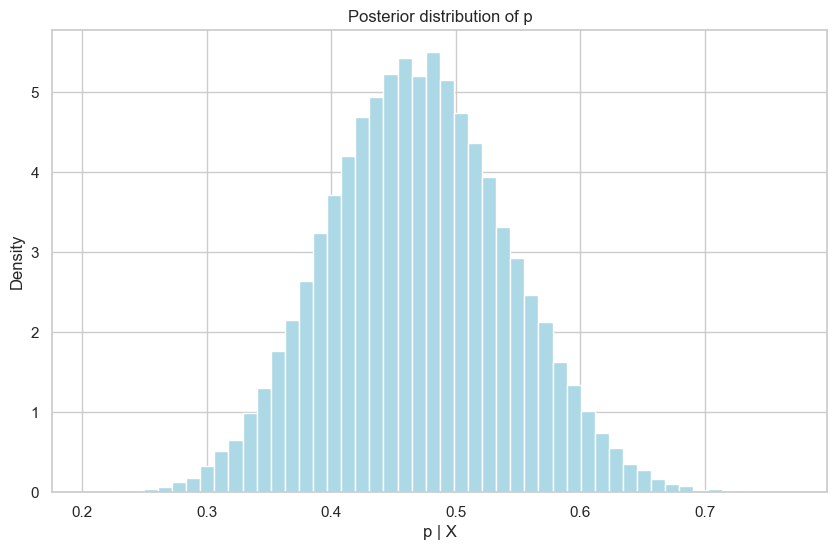

In [4]:
# q2 Gibbs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the random number seed
rng = np.random.default_rng(10)

# Parameters
x = 6
alpha = 20
beta = 20
lambda_param = 18
obs = 50000
burn = 1000

# Initialize lists for storing samples
ns = np.zeros(obs)
ps = np.zeros(obs)

# Initial values
n = x
p = 0.5

for i in tqdm(range(obs)):
    newn = x + rng.poisson((1 - p) * lambda_param)
    newp = rng.beta(alpha + x, beta + n - x)
    ns[i] = newn
    ps[i] = newp
    n = newn
    p = newp

# Compute means after burn-in
En = np.mean(ns[burn:])
Ep = np.mean(ps[burn:])
print(f"Mean of n: {En}")
print(f"Mean of p: {Ep}")

# 95% credible set for n
n_lower_bound = np.percentile(ns[burn:], 2.5)
n_upper_bound = np.percentile(ns[burn:], 97.5)
print(f"95% credible interval for n: [{n_lower_bound}, {n_upper_bound}]")

# 95% credible set for p
p_lower_bound = np.percentile(ps[burn:], 2.5)
p_upper_bound = np.percentile(ps[burn:], 97.5)
print(f"95% credible interval for p: [{p_lower_bound}, {p_upper_bound}]")

# Histogram for p
plt.figure(figsize=(10, 6))
plt.hist(ps[burn:], bins=50, color="lightblue", density=True)
plt.xlabel("p | X")
plt.ylabel("Density")
plt.title("Posterior distribution of p")
plt.grid(True)
plt.show()

## 3. Amanita muscaria
With its bright red, sometimes dinner-plate-sized caps, the fly agaric (Amanita muscaria) is one of the most striking of all mushrooms (Fig. 1a). The white warts that adorn the cap, the white gills, a well-developed ring, and the distinctive volva of concentric rings distinguish the fly agaric from all other red mushrooms. The spores of the mushroom print white, are elliptical, and have a larger axis in the range of 7 to 13 µm (Fig. 1b).

Measurements of the diameter $X$ of spores for $n = 51$ mushrooms are given in the following table:

````{panels}
:container: container-fluid 
:column: col-lg-6 col-md-6 col-sm-6 col-xs-12 
:card: shadow-none border-0

```{figure} ../images/Amanita_Muscaria_in_Eastern_Europe_Lithuania_Wikipedia.jpg
:width: 100%
:name: example1

Fly agaric or Amanita muscaria
```

---

```{figure} ../images/amanita-muscaria-sp2.jpg
:width: 100%
:name: example2

Spores of Amanita muscaria.
```

````
$$
\begin{array}{c c c c c c c c c c}
\hline
10 & 11 & 12 & 9  & 10 & 11 & 13 & 12 & 10 & 11 \\ 
11 & 13 & 9  & 10 & 9  & 10 & 8  & 12 & 10 & 11 \\ 
9  & 10 & 7  & 11 & 8  & 9  & 11 & 11 & 10 & 12 \\ 
10 & 8  & 7  & 11 & 12 & 10 & 9  & 10 & 11 & 10 \\ 
8  & 10 & 10 & 8  & 9  & 10 & 13 & 9  & 12 & 9  \\ 
9  &    &    &    &    &    &    &    &    &    \\ 
\hline
\end{array}
$$

Assume that the measurements are normally distributed with mean $\mu$ and variance $\sigma^2$, but both parameters are unknown and of interest. Suppose that the prior on $\mu$ is normal $N (12, 2^2)$ and the prior on $\tau = 1/\sigma^2$ is gamma $\text{Ga}(2, 4)$.

1. Develop a Gibbs sampling algorithm and find Bayes estimators of $\mu$ and $\tau$.

2. If an inverse gamma $\text{InvGa}(4, 2)$ is placed on $\sigma^2$, would the solution be different? Develop a Gibbs sampling for this case keeping the prior on $\mu$ as in 1.

3. Develop a Metropolis algorithm for the priors as in 1. Choice of proposal distributions is up to you.


```{admonition} Solution
:class: tip, dropdown

Solution provided by TA Jason Naramore.

1.

Likelihood: 

$\mathcal{N}(\mu,\sigma^2)$  
  
Prior for $\mu$: 

$\mathcal{N}(12,2^2$)  
  
Prior for $1/\sigma^2$ or $\tau$: 

$\mathcal{Ga}(2,4)$  

Joint conditional:

$$ \prod_{i=1}^n \left( \frac{\tau^{1/2}}{\sqrt{2\pi}} e^{-\frac{\tau}{2}(y_i-\mu)^2}\right) \left( \frac{1}{\sqrt{2\pi2^2}} e^{-\frac{1}{(2)2^2}(\mu-12)^2}\right) \left( \frac{\beta^\alpha}{\Gamma(\alpha)}\tau^{\alpha-1}e^{-\beta \tau} \right)$$

Recognize these full conditionals are same ase those derived in GIBBS.pdf and Greg's Office Hours 2.20.2024. See those documents for detailed steps.

$\mu | y, \sigma^2$: 

$$\mathcal{N}\left(\frac{\tau \sum_{i=1}^n y_i + \tau_0 \mu_0}{n\tau + \tau_0},\frac{1}{n \tau + \tau_0}\right)$$

$\tau | y, \mu$:  

$$ \mathcal{Ga} \left( n/2 + a, 1/2 \sum_{i=1}^n (y_i - \mu)^2 + b \right) $$

See hidden code below for Metropolis and PyMC answers as well.
```

10.118054011070178
0.46428843343116727


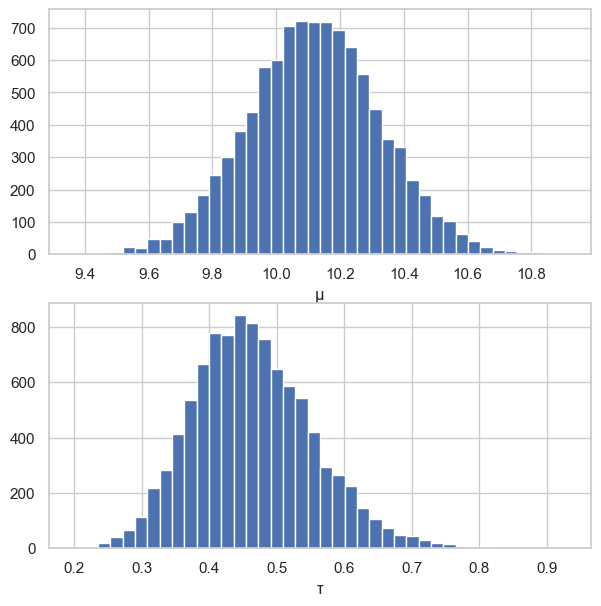

In [9]:
# Q3 Gibbs
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# fmt: off
y = np.array(
            [10, 11, 12, 9, 10, 11, 13, 12, 10, 11,
             11, 13, 9, 10, 9, 10, 8, 12, 10, 11,
              9, 10, 7, 11, 8, 9, 11, 11, 10, 12,
             10, 8, 7, 11, 12, 10, 9, 10, 11, 10,
              8, 10, 10, 8, 9, 10, 13, 9, 12, 9, 9]
            )
# fmt: on

# code is identical to GIBBS.pdf, with different hyperparameters
np.random.seed(100)
n = len(y)
NN = 10000
mus = np.array([])
taus = np.array([])
sumdata = np.sum(y)
# hyperparameters
mu0 = 12
tau0 = 1 / (2**2)
a = 2
b = 4

# start,initialvalues
mu = 12
tau = 1 / 4
for i in range(NN):
    newmu = np.random.normal(
        (tau * sumdata + tau0 * mu0) / (tau0 + n * tau),
        np.sqrt(1 / (tau0 + n * tau)),
    )
    par = b + 1 / 2 * np.sum((y - mu) ** 2)
    newtau = np.random.gamma(a + n / 2, 1 / par)
    # par is rate
    mus = np.append(mus, newmu)
    taus = np.append(taus, newtau)
    mu = newmu
    tau = newtau


burn = 200
mus = mus[burn:NN]
taus = taus[burn:NN]

print(np.mean(mus))
print(np.mean(taus))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.hist(mus, 40)
ax1.set_xlabel("μ")
ax2.hist(taus, 40)
ax2.set_xlabel("τ")
plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

acceptance rate: 0.744
np.mean(mu_samples_burned)=10.118
np.var(mu_samples_burned)=0.045
np.mean(tau_samples_burned)=0.467
np.var(tau_samples_burned)=0.008


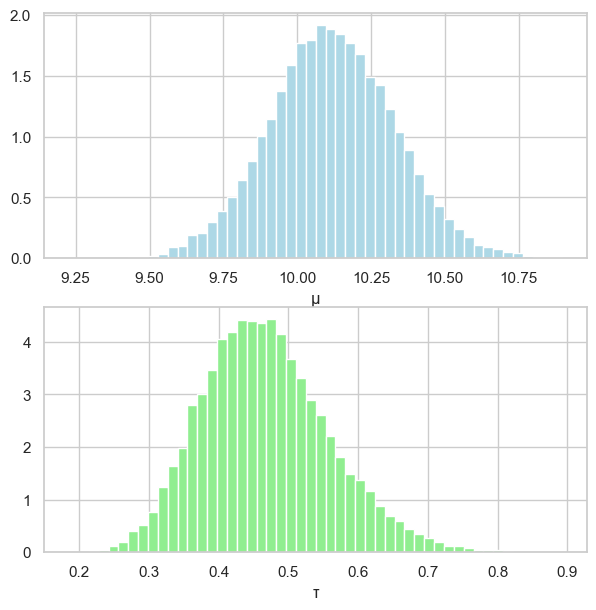

[ 9.71231639 10.51936398]
[0.30614833 0.6493451 ]


In [8]:
# Q3 Metropolis
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from tqdm.auto import tqdm

# fmt: off
y = np.array(
            [10, 11, 12, 9, 10, 11, 13, 12, 10, 11,
             11, 13, 9, 10, 9, 10, 8, 12, 10, 11,
              9, 10, 7, 11, 8, 9, 11, 11, 10, 12,
             10, 8, 7, 11, 12, 10, 9, 10, 11, 10,
              8, 10, 10, 8, 9, 10, 13, 9, 12, 9, 9]
            )
# fmt: on


def normal_likelihood(y, mu, tau):
    y_term = (y - mu) ** 2
    return np.prod(np.sqrt(tau) * np.exp(-tau / 2 * y_term))


def mu_prior(mu):
    return np.exp(-1 / 8 * (mu - 12) ** 2)


def tau_prior(tau):
    return tau * np.exp(-4 * tau)


seed = 123
rng = np.random.default_rng(seed)

obs = 50000
burn = 500
accepted = np.zeros(obs)

mu_samples = np.zeros(obs)
tau_samples = np.zeros(obs)

# pre-generate uniform randoms
unif = rng.uniform(size=obs)
mu_unif = rng.uniform(size=obs, low=-0.1, high=0.1)
tau_unif = rng.uniform(size=obs, low=-0.1, high=0.1)

mu = 12
tau = 1 / 4

for i in tqdm(range(obs)):
    # proposals
    mu_prop = mu + mu_unif[i]
    tau_prop = tau + tau_unif[i]

    # acceptance ratio
    ar = (
        normal_likelihood(y, mu_prop, tau_prop)
        * mu_prior(mu_prop)
        * tau_prior(tau_prop)
    ) / (normal_likelihood(y, mu, tau) * mu_prior(mu) * tau_prior(tau))

    ρ = min(ar, 1)

    if unif[i] < ρ:
        mu = mu_prop
        tau = tau_prop
        accepted[i] = 1

    mu_samples[i] = mu
    tau_samples[i] = tau

print(f"acceptance rate: {accepted.sum()/obs:.3f}")

# burning some samples (set in burn var above)
mu_samples_burned = mu_samples[burn:]
tau_samples_burned = tau_samples[burn:]

print(f"{np.mean(mu_samples_burned)=:.3f}")
print(f"{np.var(mu_samples_burned)=:.3f}")
print(f"{np.mean(tau_samples_burned)=:.3f}")
print(f"{np.var(tau_samples_burned)=:.3f}")

# posterior densities
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.grid(True)
ax1.hist(mu_samples_burned, color="lightblue", density=True, bins=50)
ax1.set_xlabel("μ")

ax2.grid(True)
ax2.hist(tau_samples_burned, color="lightgreen", density=True, bins=50)
ax2.set_xlabel("τ")

plt.show()

print(az.hdi(mu_samples))
print(az.hdi(tau_samples))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


       mean     sd  hdi_2.5%  hdi_97.5%
mu   10.116  0.210     9.691     10.524
tau   0.464  0.088     0.302      0.641


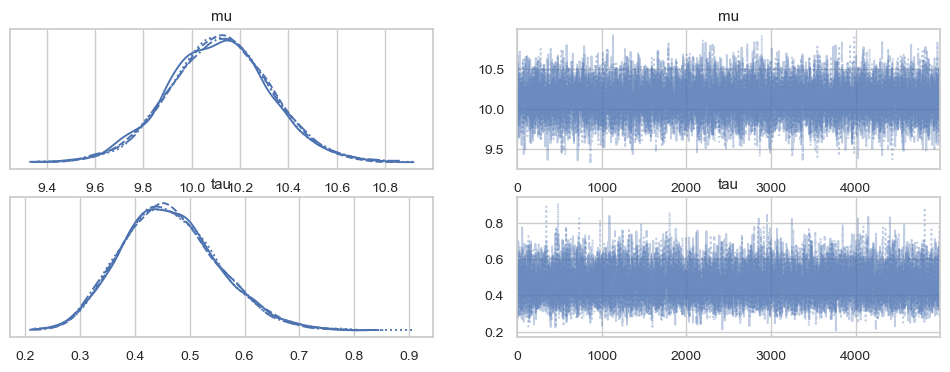

In [7]:
# Q3 PyMC
import pymc as pm
import numpy as np
import arviz as az

# fmt: off
y = np.array(
            [10, 11, 12, 9, 10, 11, 13, 12, 10, 11,
             11, 13, 9, 10, 9, 10, 8, 12, 10, 11,
              9, 10, 7, 11, 8, 9, 11, 11, 10, 12,
             10, 8, 7, 11, 12, 10, 9, 10, 11, 10,
              8, 10, 10, 8, 9, 10, 13, 9, 12, 9, 9]
            )
# fmt: on


with pm.Model() as m:
    # priors
    mu = pm.Normal("mu", mu=12, tau=1 / 4)
    tau = pm.Gamma("tau", alpha=2, beta=4)

    # Likelihood
    pm.Normal("likelihood", mu=mu, tau=tau, observed=y)

    # sampling
    trace = pm.sample(5000, target_accept=0.95)

print(az.summary(trace, hdi_prob=0.95, kind="stats"))

az.plot_trace(trace)
plt.show()

## 4. Jeremy via Metropolis
The Jeremy example was solved exactly (as a conjugate problem) and by using WinBUGS. Recall that Jeremy’s IQ test score $X$ was modeled as normal $N(\theta, 80)$, while the location parameter $\theta$ had prior $N(110, 120)$. We could think of $\theta$ as Jeremy’s intrinsic IQ level. On his IQ test Jeremy scored $X = 98$.

Develop a Metropolis MCMC scheme for sampling from the posterior.

Sample the proposal $\theta_p$ from a Cauchy distribution centered at the current state of the chain $\theta$.

``` python
theta_prop = theta + 10 * np.tan(np.pi * np.random.rand() - np.pi / 2)
```

Since the proposal distribution depends on $(\theta_p - \theta)^2$, it does not factor into the acceptance ratio $\rho$. Your target is the product of the likelihood and prior and does not need to be normalized to be a distribution. Start with $\theta = 100$ and burn in 500 simulations. Save 50,000 simulations (not including the burn-in).

1. Estimate the posterior mean, posterior standard deviation, find the median, and 95% equal-tailed credible set.

2. Plot the normalized histogram and superimpose the theoretical posterior density.

```{admonition} Solution
:class: tip, dropdown

Solution to be added. Feel free to share yours on Ed Discussion!
```


## 5. Jeremy via Gibbs Sampling
Translate the following WinBUGS code into a custom-made Gibbs Sampling program in MATLAB.

```matlab
model {
  x ~ dnorm(mu, tau)
  pprec <- 1/120
  mu ~ dnorm(110, pprec)
  tau ~ dgamma(0.01, 1)
  sig2 <- 1/tau
}

DATA
list(x = 98)

INITS
list(mu = 100, tau = 0.01)
```

Find full conditionals for $\mu$ and $\tau$. Compare Bayes summaries (posterior mean, median, 2.5 and 97.5 percentiles, histograms) between WinBUGS and Gibbs outputs.

```{admonition} Solution
:class: tip, dropdown

Solution to be added. Feel free to share yours on Ed Discussion!

```

## 6. Gibbs with Metropolis Step (Georgia Deaths from Kidney Cancer 1985-1989 by Counties)
When in a Gibbs sampling scheme, one or more full conditionals are not tractable, their function can be replaced by a so-called Metropolis step. An example with a Metropolis step is given below.

The data set contains death counts from Kidney Cancer for 159 Georgia counties as well as the county population size. The data are from years 1985-1989. It is of interest to estimate the death rate (per 100,000) for each county, as well as the all-Georgia death rate.

The model is Poisson $\text{Poi}(\lambda_i n_i)$, $i = 1, \ldots, k$ where $n_i$ is the population size divided by 100,000 for county $i$; here $k = 169$. Also, $n = n_1 + \ldots + n_k$ is the population of Georgia in units of 100,000. The model is as follows:

$$
\begin{align*}
y_i &\sim \text{Poi}(\lambda_i n_i), \quad i = 1, \ldots, k \\
\lambda_i &\sim \text{Ga}(\alpha, \beta), \quad i = 1, \ldots, k \\
\alpha &\sim U(0, A) \\
\beta &\sim U(0, B)
\end{align*}
$$

for specified constants $A$ and $B$. The joint distribution is:

$$
f(y, \lambda, \alpha, \beta) = \prod_{i=1}^k \left[ \frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i n_i} \times \frac{\beta^\alpha \lambda_i^{\alpha-1}}{\Gamma(\alpha)} e^{-\beta \lambda_i} \right] \times \frac{1}{A} 1(0 \leq \alpha \leq A) \times \frac{1}{B} 1(0 \leq \beta \leq B)
$$

$$
\pi(\lambda_i \mid y, \lambda_{\neg i}, \alpha, \beta) \propto f(y, \lambda, \alpha, \beta) \propto \lambda_i^{y_i} e^{-\lambda_i n_i} \lambda_i^{\alpha-1} e^{-\beta \lambda_i}, \quad i = 1, \ldots, k
$$

Therefore,

$$
[\lambda_i \mid y, \lambda_{\neg i}, \alpha, \beta] \sim \text{Ga}(y_i + \alpha, n_i + \beta), \quad i = 1, \ldots, k
$$

$$
\pi(\alpha \mid y, \lambda, \beta) \propto f(y, \lambda, \alpha, \beta) \propto \left( \frac{\beta^k \prod_{i=1}^k \lambda_i}{\Gamma(\alpha)} \right)^\alpha 1(0 \leq \alpha \leq A)
$$

$$
\pi(\beta \mid y, \lambda, \alpha) \propto f(y, \lambda, \alpha, \beta) \propto \beta^{k\alpha} e^{-\beta \sum_{i=1}^k y_i} \times \frac{1}{B} 1(0 \leq \beta \leq B)
$$

Therefore,

$$
[\beta \mid y, \lambda, \alpha] \sim \text{Ga} \left( k\alpha + 1, \sum_{i=1}^k y_i \right) 1(0 \leq \beta \leq B)
$$

The Metropolis Step for generating $\alpha$:
Proposal $\alpha' \sim N(\alpha, \sigma^2)$. The Metropolis ratio depends on the target only,

$$
r = \left( \frac{\Gamma(\alpha)}{\Gamma(\alpha')} \right)^k \times C^{\alpha' - \alpha} \times 1(0 \leq \alpha' \leq A),
$$

for $C = \beta^k \prod_{i=1}^k \lambda_i$.

```{admonition} Solution
:class: tip, dropdown

See [](../unit5/Unit5-gibbsintro.ipynb).
```

## 7. Exponential Survival Times
Survival times of $n$ post-surgery patients assigned to a treatment group are given as $T_1, \ldots, T_n$. In a control group of $m$ post-surgery patients the survival times are $C_1, \ldots, C_m$. The proposed model is

$$
\begin{align*}
T_i &\sim E(\lambda \theta), \quad i = 1, \ldots, n \\
C_i &\sim E(\lambda), \quad i = 1, \ldots, m \\
\lambda &> 0, \\
\theta &> 0,
\end{align*}
$$

where $T_i$'s and $C_i$'s are assumed independent. To complete the model assume the following priors on $\lambda$ and $\theta$,

$$
\pi(\lambda) = \frac{1}{\lambda}, \quad \text{[Jeffreys’ choice]}
$$
$$
\theta \sim \text{Ga}(1/2, 1/2),
$$

where gamma is parameterized via the rate parameter.

1. Show that the likelihood and posterior depend on $T = \sum_{i=1}^n T_i$ and $C = \sum_{i=1}^m C_i$.

2. Identify full conditionals for $[\lambda \mid \theta, T, C]$ and $[\theta \mid \lambda, T, C]$.

3. For $n = 10$, $m = 12$, $T = 18.26$, and $C = 26.78$, set up a Gibbs sampling scheme.

4. From a Gibbs sample of size 10000 estimate $\theta$ and find a 95% equi-tailed credible set. Is the credible set containing 1? Discuss.

5. How would you deal with the analysis if some times are censored? Repeat the analysis if $T_{10} = 2.12$, $C_{11} = 1.54$, and $C_{12} = 1.98$ are in fact censored times.

```{admonition} Solution
:class: tip, dropdown

Solution to be added. Feel free to share yours on Ed Discussion! This problem is challenging, since we haven't learned about censoring yet.

Hint: The posterior is proportional to

$$
\prod_{i=1}^n (\lambda \theta \exp\{-\lambda \theta T_i\}) \times \prod_{i=1}^m (\lambda \exp\{-\lambda C_i\}) \times \frac{1}{\lambda} \times \theta^{1/2-1} \exp\{-\theta/2\}
$$

The above product is proportional to

$$
\lambda^{m+n-1} \exp\{-\lambda(\theta T + C)\},
$$

when $\theta$ is constant, and to

$$
\theta^{n-1/2} \exp\{-(\lambda T + 1/2)\theta\},
$$

when $\lambda$ is constant. Thus,

$$
[\lambda \mid \theta, T, C] \sim \text{Gamma}(m+n, \theta T + C) \quad \text{and} \quad [\theta \mid \lambda, T, C] \sim \text{Gamma}(n+1/2, \lambda T + 1/2).
$$


```


## 8. Testing the Effectiveness of a Seasonal Flu Shot
Assume 30 individuals are given a flu shot at the start of winter. At the end of winter, follow up to see whether they contracted flu. Let

$$
x_i =
\begin{cases}
1, & \text{no flu (shot effective)} \\
0, & \text{flu (shot not effective)}
\end{cases}
$$

Suppose the 30th individual was unavailable for follow-up. Define $y = \sum_{i=1}^{29} x_i$. If $p$ is the probability the shot is effective, then

$$
f(y \mid p) = \binom{29}{y} p^y (1 - p)^{29-y}, \quad y = 0, 1, \ldots, 29
$$

With the complete data ($y$ plus $x_{30}$),

$$
f(y, x_{30} \mid p) = \binom{30}{y + x_{30}} p^{y + x_{30}} (1 - p)^{30 - y - x_{30}}, \quad y + x_{30} = 0, 1, \ldots, 30
$$

With a uniform prior on $p$ and $[x_{30} \mid p] \sim \text{Ber}(p)$ the joint distribution of $[p, x_{30} \mid y]$ is proportional to $f(y, x_{30} \mid p)$. Thus, the full conditionals are

$$
[p \mid x_{30}, y] \sim \text{Be}(y + x_{30} + 1, 30 - y - x_{30} + 1)
$$

and

$$
[x_{30} \mid y, p] \sim \text{Ber}(p)
$$

If $y = 21$, estimate $p$ using a Gibbs sampler that uses these two full conditionals.


```{admonition} Solution
:class: tip, dropdown

Solution to be added. Feel free to share yours on Ed Discussion!

```